<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#GetContacts-flareplots,-fingerprints-and-heatmaps" data-toc-modified-id="GetContacts-flareplots,-fingerprints-and-heatmaps-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>GetContacts flareplots, fingerprints and heatmaps</a></span></li><li><span><a href="#Preparation" data-toc-modified-id="Preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preparation</a></span><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Choose-a-selection" data-toc-modified-id="Choose-a-selection-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Choose a selection</a></span></li><li><span><a href="#Merge-the-data" data-toc-modified-id="Merge-the-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Merge the data</a></span></li><li><span><a href="#Apply-a-cutoff" data-toc-modified-id="Apply-a-cutoff-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Apply a cutoff</a></span></li></ul></li><li><span><a href="#Visualize-the-frequencies" data-toc-modified-id="Visualize-the-frequencies-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualize the frequencies</a></span><ul class="toc-item"><li><span><a href="#Flareplots" data-toc-modified-id="Flareplots-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Flareplots</a></span></li><li><span><a href="#Fingerprints-and-heatmaps" data-toc-modified-id="Fingerprints-and-heatmaps-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Fingerprints and heatmaps</a></span></li></ul></li><li><span><a href="#Compare-more-than-two-systems" data-toc-modified-id="Compare-more-than-two-systems-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compare more than two systems</a></span></li></ul></div>

# GetContacts flareplots, fingerprints and heatmaps

In [1]:
import matplotlib.pyplot as plt

import gc_analysis
from gc_analysis import utils

# Preparation
## Load the data

At first all frequencies are calculated using **GetContacts**.
More information can be found on their github page:
    https://getcontacts.github.io/.

For the calculation only the interaction type was specified but no selection. The selection will be chosen later on in this script.

In [2]:
wildtype = gc_analysis.read_tsv("../data/wt_freq.tsv")
wildtype.head()

,res 1,number 1,res 2,number 2,frequency
0,PRO,386,SER,163,0.583
1,PHE,385,SER,177,0.930
2,PHE,117,SER,351,0.265
3,TYR,317,TYR,92,0.965
4,PRO,342,SER,122,0.805


## Choose a selection

The `gc_analysis.select` method makes selecting residues of interest easy. The method returns a new `pandas.DataFrame`.
Either the exact selection (`kind="selection"`) can be provided...

In [3]:
_df = gc_analysis.select(
    wildtype,
     [(317, 318, 319), (92, 97)],
    kind="selection",)
_df

,res 1,number 1,res 2,number 2,frequency
3,TYR,317,TYR,92,0.965
56,TYR,318,TYR,92,0.575
69,ARG,97,TYR,317,0.738
94,ARG,97,PHE,319,0.632
211,ARG,97,TYR,318,0.184


.. or entire ranges (`kind="range"`). Any iterable that contains iterable works.

In [4]:
_df = gc_analysis.select(
    wildtype, 
    [range(1,216), range(313,322)], 
    kind="selection",
)
_df.shape

(51, 5)

In [5]:
wildtype_h3 = gc_analysis.select(
    wildtype, 
    [(1,215), (313,321)],
    kind="range",
)
print(f"The results of both ways are equal:\n{all(wildtype_h3 == _df)}")

wildtype_h3.head()

The results of both ways are equal:
True


,res 1,number 1,res 2,number 2,frequency
3,TYR,317,TYR,92,0.965
5,LEU,47,TYR,318,0.885
22,TYR,318,TYR,50,0.937
26,PHE,319,TYR,37,0.973
29,ARG,97,ASP,316,0.555


Everything we have done so far can be repeated for a second datafile.

In [6]:
mutant = gc_analysis.read_tsv("../data/mt_freq.tsv")
mutant_h3 = gc_analysis.select(mutant, [(1,215), (313,321)])
mutant_h3.head()

,res 1,number 1,res 2,number 2,frequency
0,PHE,319,TYR,36,0.496
1,GLN,55,TYR,318,0.664
3,ASP,320,GLN,55,0.234
10,TYR,318,TYR,49,0.690
15,GLN,89,PHE,319,0.033


## Merge the data

The data is stored as a `pandas.DataFrame` meaning **pandas** can be used to conveniently merge the data.

`utils.merge_on_number` handles the merging of data on the sequence numbers.

In [7]:
merged_df = utils.merge_on_number([wildtype_h3, mutant_h3])
merged_df.columns = ["wildtype", "mutant"]
merged_df = utils.sort_index(merged_df)
merged_df.tail()

,,wildtype,mutant
47,320,0.087,0.000
50,320,0.000,0.000
55,320,0.000,0.234
56,320,0.000,0.040
57,320,0.000,0.001


If both Datasets are from the same system with the very same sequence, the merging can also be done on both residue number and name. 
To re-label the residue numbers according to their sequence, the sequence information is extracted from their respective topology with `utils.sequencer`.

In [8]:
sequences = utils.sequencer(
    ["../data/wt.parm7", "../data/mt.parm7"]
)
sequences.columns = ["wildtype", "mutant"]
sequences.head()

,wildtype,mutant
resSeq,,
1,GLU,ASP
2,ILE,ILE
3,VAL,GLN
4,LEU,LEU
5,THR,THR


In [9]:
# concatenate the resiude number into the residue name and rename from threeletter code to oneletter code
for column in sequences.columns:
    sequences[column] = sequences[column].apply(lambda x: utils.three2one[x]) + \
                        sequences.index.map(lambda x: f"{x:03d}")
sequences.head()

,wildtype,mutant
resSeq,,
1,E001,D001
2,I002,I002
3,V003,Q003
4,L004,L004
5,T005,T005


In [10]:
merged_df = utils.label_merged(merged_df, sequences)
merged_df

wildtype  mutant
wildtype wildtype mutant mutant                  
S030     Y317     S030   Y317       0.000   0.000
S031     Y317     S031   Y317       0.000   0.005
         Y318     S031   Y318       0.000   0.002
S032     Y317     Y032   Y317       0.004   0.000
Y033     Y318     L033   Y318       0.000   0.001
...                                   ...     ...
L047     D320     L047   D320       0.087   0.000
Y050     D320     A050   D320       0.000   0.000
R055     D320     Q055   D320       0.000   0.234
A056     D320     S056   D320       0.000   0.040
T057     D320     G057   D320       0.000   0.001

[141 rows x 2 columns]

## Apply a cutoff

All contact_frequencies with a frequency lower than the cutoff are discarded for plotting.

In [11]:
CUTOFF = 0.6

rel_cut = merged_df[merged_df.max(axis=1) - merged_df.min(axis=1) > CUTOFF]
abs_cut = merged_df[(merged_df > CUTOFF).any(axis=1)]

# Visualize the frequencies

## Flareplots

To visualize a single systems contacts the method `gc_analysis.flareplot` can be used.
The function expects a singe column of data.

Below are some examples that show what can be done.

In [12]:
cut_wt = utils.select_system(rel_cut,"wildtype")
cut_mt = utils.select_system(rel_cut, "mutant")

cut_wt.head()

wildtype  wildtype
R046      Y318        0.000
L047      Y318        0.885
R055      Y318        0.000
R097      D313        0.673
          F319        0.632
Name: wildtype, dtype: float64

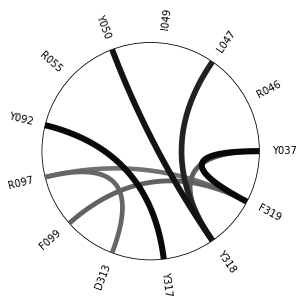

In [13]:
flareplot = gc_analysis.flareplot(cut_wt)

Text(0.5, 1.0, 'Selection')

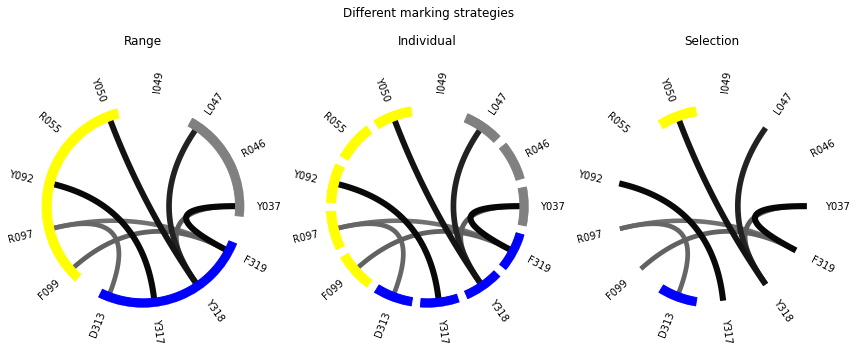

In [14]:
fig = plt.figure(tight_layout=True, figsize=(12,5))
fig.suptitle("Different marking strategies")
ax1 = fig.add_subplot(131,projection='polar')
ax2 = fig.add_subplot(132,projection='polar')
ax3 = fig.add_subplot(133,projection='polar')


marking = [
    utils.Mark("A", "grey", range(49)),
    utils.Mark("B", "yellow", [50, 215]),
    utils.Mark("H3", "blue", (313,321)),
]
fp1 = gc_analysis.flareplot(cut_wt, ax=ax1)
fp1.mark(marking, strategy_name="range")
fp1.ax.set_title("Range", pad=60)


fp2 = gc_analysis.flareplot(cut_wt, ax=ax2)
fp2.mark(marking, strategy_name="individual", gap_scale=0.1)
fp2.ax.set_title("Individual", pad=60)


# selection must be in index else a key value is thrown!
marking = [
    utils.Mark("B", "yellow", [50]),
    utils.Mark("H3", "blue", [313]),
]

fp3 = gc_analysis.flareplot(cut_wt, ax=ax3)
fp3.mark(marking, strategy_name="selection", gap_scale=0.1)
fp3.ax.set_title("Selection", pad=60)

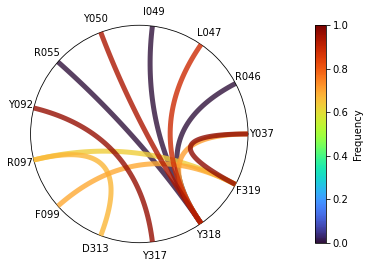

In [15]:
flareplot = gc_analysis.flareplot(cut_wt, 
                                  linewidth=5, 
                                  scale_thickness=False,
                                  cmap="turbo",
                                  cbar=True,
                                  alpha=0.8,
                                 )
flareplot.reset_labels()

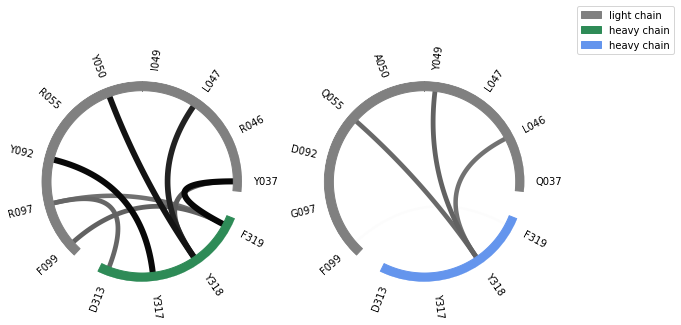

In [16]:
fig = plt.figure(tight_layout=True, figsize=(8,5))
ax1 = fig.add_subplot(1,2,1,projection='polar')
ax2 = fig.add_subplot(1,2,2,projection='polar')

marking = [["light chain", "grey",range(1,216)],
           ["heavy chain", "seagreen", range(216,436)]]

flare1 = gc_analysis.flareplot(cut_wt, ax=ax1)
flare1.rotate_labels()
flare1.mark(marking)

marking[0][0] = None
marking[1][1] = "cornflowerblue"

flare2 = gc_analysis.flareplot(cut_mt, ax=ax2)
flare2.rotate_labels()
flare2.mark(marking)

fig.legend(loc='upper left', bbox_to_anchor=(1,1))

## Fingerprints and heatmaps

The functions `fingerprint` and `heatmap` can be used to compare two systems.
`fingerprint` clusters the data internally using a hierarchical clustering, while `heatmap` plots the data in the same order as they appear in the DataFrame.

The labels in the plot match the indices of the DataFrame. To change the labels of the plot, the indices of the DataFrame have to be changed.

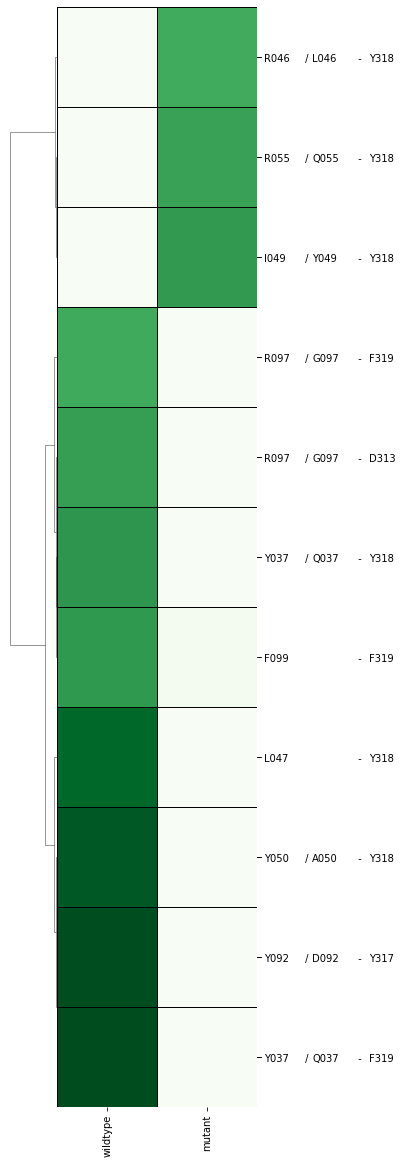

In [17]:
finger = gc_analysis.fingerprint(rel_cut)

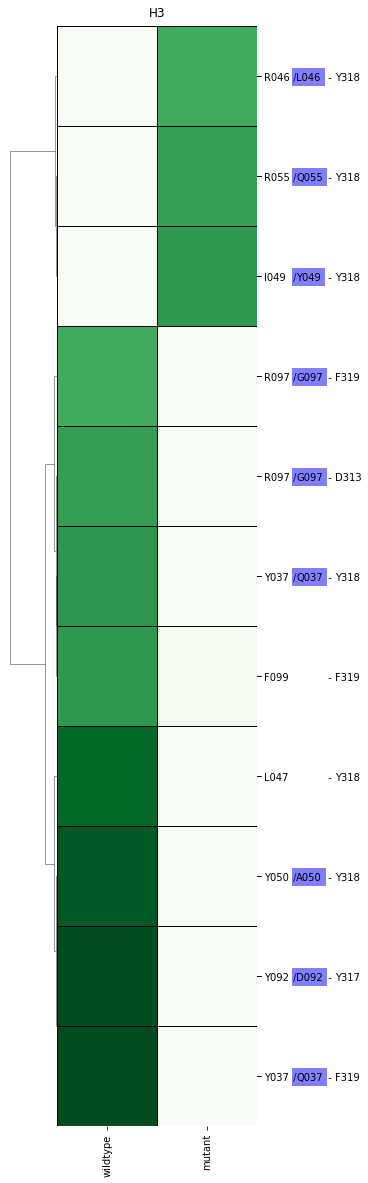

In [18]:
finger.set_title("H3")
finger.align_labels(factor=0.6)
finger.color_labels(["none", "blue"])

In [19]:
finger.recolor_matrix(["Blues", "Greens"], gc_analysis.utils.mask_gen(1,1))
for label in finger.ax.get_yticklabels():
    if label.get_text() == "Tyr318":
        label.set_bbox(dict(facecolor="red", alpha=0.3, ec='none'))

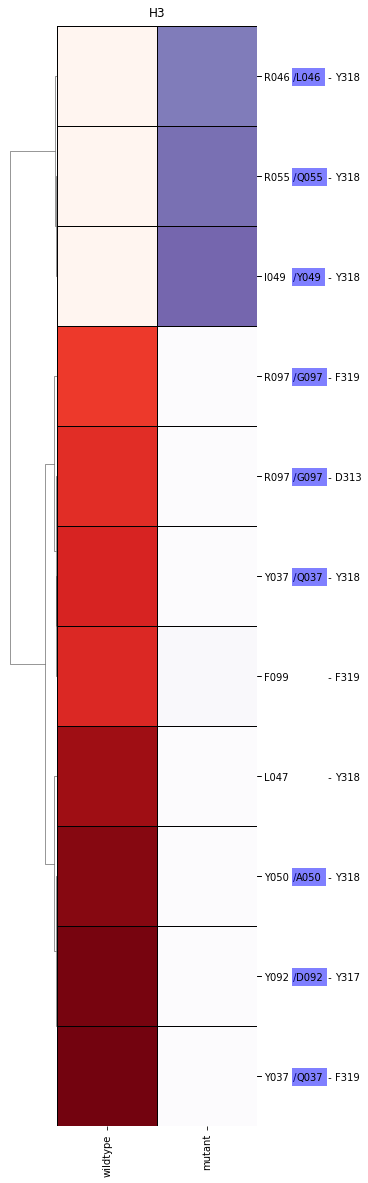

In [20]:
finger.recolor_matrix(["Reds", "Purples"], gc_analysis.utils.mask_gen(1,1))

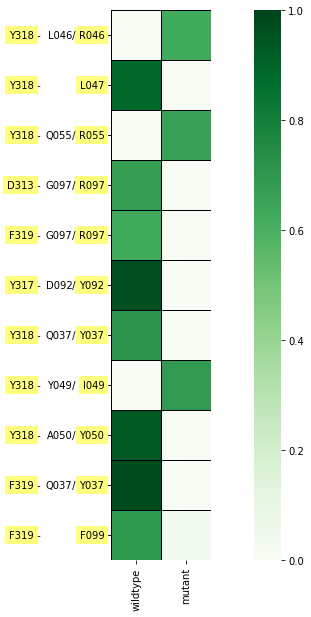

In [21]:
hm = gc_analysis.heatmap(rel_cut)
hm.fig.set_size_inches(hm.fig.get_size_inches()*0.5)
hm.align_labels(factor = -0.6)
hm.color_labels(["yellow"])
None # so only one fig is shown

# Compare more than two systems

Comparing more than two systems is easy. It is done exactly the same way as before.

In [22]:
mutant2_h2 = gc_analysis.select(mutant, [(1,215), (265,280)])

merged_df = utils.merge_on_number([wildtype_h3, mutant_h3, mutant2_h2])
merged_df.columns = ["wildtype", "mutant", "mutant2"]
merged_df = utils.sort_index(merged_df)

sequences = utils.sequencer(["../data/wt.parm7", "../data/mt.parm7", "../data/mt.parm7"])
sequences.columns = ["wildtype", "mutant", "mutant2"]
for column in sequences.columns:
    sequences[column] = sequences[column].apply(lambda x: utils.three2one[x]) + \
                        sequences.index.map(lambda x: f"{x:03d}")

merged_df = utils.label_merged(merged_df, sequences)
abs_cut = merged_df[(merged_df > CUTOFF).any(axis=1)]
abs_cut.head()

wildtype  mutant  mutant2
wildtype wildtype mutant mutant mutant2 mutant2                           
R046     Y318     L046   Y318   L046    Y318        0.000   0.627      0.0
L047     Y318     L047   Y318   L047    Y318        0.885   0.001      0.0
R055     Y318     Q055   Y318   Q055    Y318        0.000   0.664      0.0
R097     D313     G097   D313   G097    D313        0.673   0.000      0.0
         Y317     G097   Y317   G097    Y317        0.738   0.148      0.0

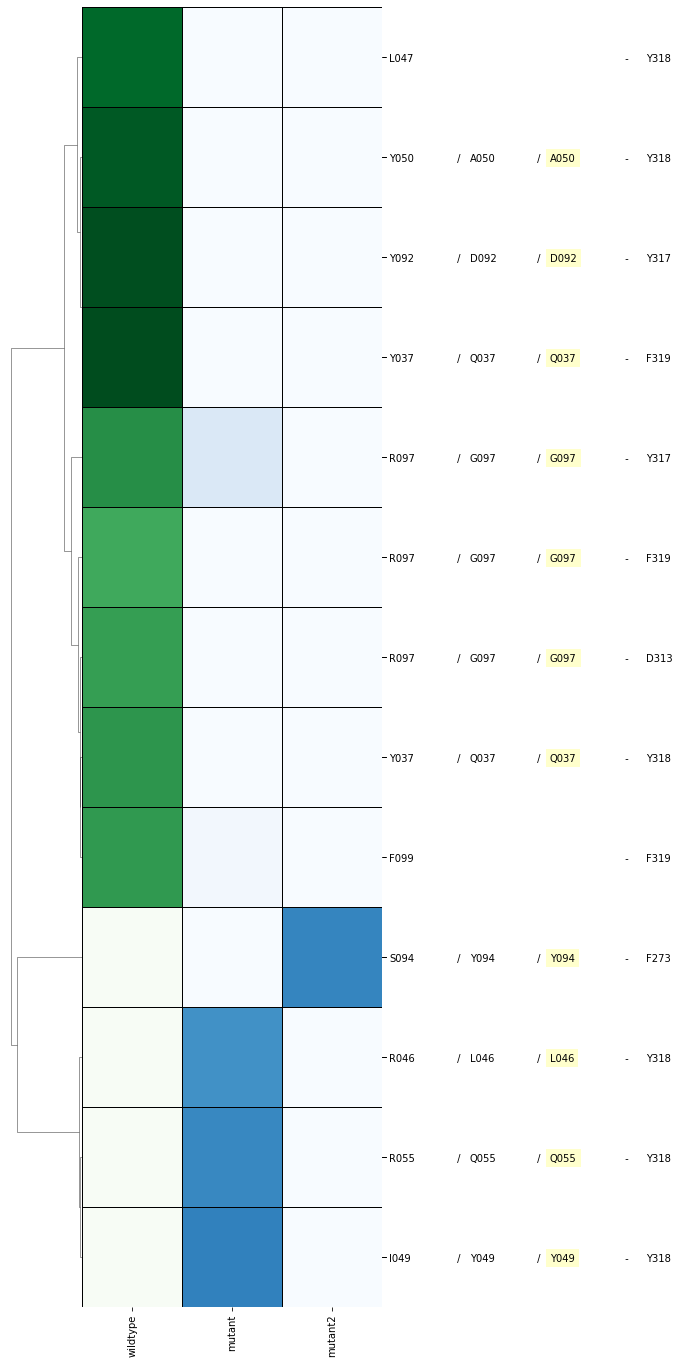

In [23]:
finger = gc_analysis.fingerprint(abs_cut)
finger.align_labels(factor=1)
finger.recolor_matrix(["Greens", "Blues"], 
                      utils.mask_gen(1,2))
finger.color_labels(["none", "none", "yellow"], alpha=0.2)

None